In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# 新段落

In [2]:
## Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
# torch.set_default_dtype(torch.float32)
torch.set_default_dtype(torch.float64)
#torch.manual_seed(13)



# Sampling parameters etc
#n_axis = 51
n_axis = 21
#n_time = 131
n_time = 21

axis = torch.linspace(0,2,n_axis, device=device)
time = torch.linspace(0,2,n_time, device=device)
Ps = torch.cartesian_prod(axis,axis,axis,time)
# Number of points
lP = Ps.shape[0]


# Initial dataset
data_axisbc = torch.linspace(0,4, 41, device=device)
data_axis = torch.linspace(-2,4, 61, device=device)
data_time = torch.linspace(0,0,1, device=device)
data_Ps = torch.cartesian_prod(data_axis,data_axisbc,data_axisbc,time)

mask = data_Ps[:,3] == 0.
X = data_Ps[mask]
#dX = data_Ps[mask]

#Y = 2*torch.cos(5*X[:,0])+2*torch.cos(5*X[:,1])+2*torch.cos(5*X[:,2])
Y = torch.exp(-5*((X[:,0]-1)**2+(X[:,1]-1)**2+(X[:,2]-1)**2))+torch.exp(-5*((X[:,0]-1)**2+(X[:,1]+1)**2+(X[:,2]-1)**2))+torch.exp(-5*((X[:,0]-1)**2+(X[:,1]-1)**2+(X[:,2]+1)**2))
#Y = torch.cos((X[:,0]-1)*5)+torch.cos((X[:,1]-1)*5)
Y = Y.view(-1,1)

#dY = -2*5*(X[:,0]-1)*torch.exp(-(X[:,0]-1)**2*5)-2*5*(X[:,1]-1)*torch.exp(-(X[:,1]-1)**2*5)-2*5*(X[:,2]-1)*torch.exp(-(X[:,2]-1)**2*5)
#dY = torch.sin(X[:,0]+2*X[:,1]+X[:,2])
#dtY = -5*(torch.sin((X[:,0]-1)*5)+torch.sin((X[:,1]-1)*5))
#dY = dY.view(-1,1)

#dX = dX.to(torch.complex64)
#dY = dY.to(torch.complex64)
X = X.to(torch.complex128)
Y = Y.to(torch.complex128)
#Y = torch.cat((Y,dY),0)

Using cuda device


In [3]:
def getVarietyPoints(base1,base2):
    x1,y1,z1 = base1.unbind(1)
    #x2,y2,z2 = base2.unbind(1)
    t1 = torch.sqrt(x1.square() + y1.square() + z1.square())
    #t2 = torch.sqrt(x2.square() + y2.square() + z2.square())
    return torch.stack([ torch.stack([x1,y1,z1,t1],1), torch.stack([x1,y1,z1,-t1],1), torch.stack([x1,-y1,z1,t1],1), torch.stack([x1,-y1,z1,-t1],1),torch.stack([x1,y1,-z1,t1],1), torch.stack([x1,y1,-z1,-t1],1), torch.stack([x1,-y1,-z1,t1],1), torch.stack([x1,-y1,-z1,-t1],1) ])
    #return torch.stack([ torch.stack([x1,y1,z1,t1],1), torch.stack([x2,y2,z2,-t2],1) ])

def Phi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    # return (pts.inner(X) * 1.j).exp().mean(0)
    return (pts.inner(X)).exp().mean(0)

def dPhi(base1, base2, X):
    pts = getVarietyPoints(base1, base2)
    return ((pts.inner(X)).exp().mul(pts[:,:,3].unsqueeze(2).repeat(1, 1, pts.inner(X).shape[2])).mean(0))


def train(N):
    for epoch in range(N):
        PhiX = Phi(MC_base1 * 1.j, MC_base2 * 1.j, X)
        #dPhiX = dPhi(MC_base1 * 1.j, MC_base2 * 1.j, dX)
        #PhiX = torch.cat((PhiX,dPhiX),1)
        A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
        LA = torch.linalg.cholesky(A)
        alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to(torch.complex128), upper=False)

        nlml = 1/(2*eps.exp()) * (Y.norm().square() - alpha.norm().square())
        nlml += (PhiX.shape[1] - PhiX.shape[0])/2 * eps
        nlml += LA.diag().real.log().sum()
        nlml += 0.5*S_diag.sum()

        opt.zero_grad()
        nlml.backward()
        opt.step()

        with torch.no_grad():
            train_pred = PhiX.H @ torch.linalg.solve_triangular(LA.H, alpha, upper=True)
            err = (train_pred.real - Y).square().mean().sqrt()
            print(26*"~" + f'\nepoch {epoch}\n\
nlml {nlml}\n\
err {err}\n\
eps {eps.exp()}\n\
base1 std {MC_base1.std(0)}\n\
base2 std {MC_base2.std(0)}\n\
min,max {train_pred.real.min().detach(),train_pred.real.max().detach()}')

In [4]:
n_MC = 500
# MC_axis = torch.linspace(-1,1, n_MC, device=device) * 30
MC_base1 = (torch.randn((n_MC, 3), device=device)).requires_grad_()
MC_base2 = (torch.randn((n_MC, 3), device=device)).requires_grad_()
# MC_base = torch.cartesian_prod(MC_axis,MC_axis).requires_grad_()
S_diag = torch.full((n_MC,), -np.log(n_MC), requires_grad=True, device=device)
# S_diag = torch.full((n_MC**2,), -np.log(n_MC**2), requires_grad=False, device=device)
eps = torch.tensor(np.log(1e-2), requires_grad=True, device=device)

In [5]:
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-1},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(20000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-2},
    {'params': eps, 'lr': 1e-2}])
#train(100000)
train(20000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-3},
    {'params': [S_diag, eps], 'lr': 1e-2}])
train(1000)
opt = torch.optim.Adam([
    {'params': [MC_base1], 'lr': 1e-3},
    {'params': [S_diag, eps], 'lr': 1e-3}])
train(300)
torch.save({
            'MC_base1': MC_base1.cpu(),
            'MC_base2': MC_base2.cpu(),
            'S_diag': S_diag.cpu(),
            'eps': eps.cpu(),
    }, "state.pt")


流式输出内容被截断，只能显示最后 5000 行内容。
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 675
nlml -668057.9359961833
err (0.0008662078923565131-5.641668256959056e-20j)
eps 7.656392787791276e-07
base1 std tensor([4.2389, 3.7419, 3.7713], device='cuda:0')
base2 std tensor([0.9732, 1.0221, 1.0402], device='cuda:0')
min,max (tensor(-0.0042, device='cuda:0'), tensor(0.9758, device='cuda:0'))
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 676
nlml -668055.9807256819
err (0.000866217785048617-5.635385650218758e-20j)
eps 7.658355960501716e-07
base1 std tensor([4.2389, 3.7419, 3.7713], device='cuda:0')
base2 std tensor([0.9732, 1.0221, 1.0402], device='cuda:0')
min,max (tensor(-0.0042, device='cuda:0'), tensor(0.9758, device='cuda:0'))
~~~~~~~~~~~~~~~~~~~~~~~~~~
epoch 677
nlml -668059.4958878285
err (0.0008662108265563547-5.641137782501273e-20j)
eps 7.658932535973515e-07
base1 std tensor([4.2389, 3.7419, 3.7714], device='cuda:0')
base2 std tensor([0.9732, 1.0221, 1.0402], device='cuda:0')
min,max (tensor(-0.0042, device='cuda:0'), tenso

In [6]:
#torch.save({
#            'MC_base1': MC_base1.cpu(),
#            'MC_base2': MC_base2.cpu(),
#            'S_diag': S_diag.cpu(),
#            'eps': eps.cpu(),
#    }, "state.pt")


st = torch.load("state.pt")
MC_base1 = st['MC_base1']
MC_base2 = st['MC_base2']
S_diag = st['S_diag']
eps = st['eps']

# Prediction
#Phi_ = Phi(MC_base * 1.j, Ps.to(torch.complex128)).to(device)
Phi_ = Phi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#dPhi_ = dPhi(MC_base1 * 1.j, MC_base2 * 1.j, Ps.to(torch.complex128).to("cpu"))
#Phi_ = torch.cat((Phi_,dPhi_),1)
PhiX = Phi(MC_base1 * 1.j, MC_base2 * 1.j, X.to("cpu"))
#dPhiX = dPhi(MC_base1 * 1.j, MC_base2 * 1.j, dX.to("cpu"))
#PhiX = torch.cat((PhiX,dPhiX),1)
A = torch.diag_embed((eps - S_diag).exp()) + PhiX @ PhiX.H
LA = torch.linalg.cholesky(A)
alpha = torch.linalg.solve_triangular(LA, PhiX @ Y.to("cpu").to(torch.complex128), upper=False)
pred = Phi_.H @ torch.linalg.solve_triangular(LA.H, alpha.to("cpu"), upper=True)
pred = pred.real

pred.detach().cpu().numpy().tofile("pred.dat")
axis.cpu().numpy().tofile("axis.dat")
time.cpu().numpy().tofile("time.dat")

<ipython-input-6-bc68cac6f340>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  st = torch.load("state.pt")


In [7]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!cp pred.dat "/content/drive/MyDrive/Colab Notebooks"
!cp axis.dat "/content/drive/MyDrive/Colab Notebooks"
!cp time.dat "/content/drive/MyDrive/Colab Notebooks"

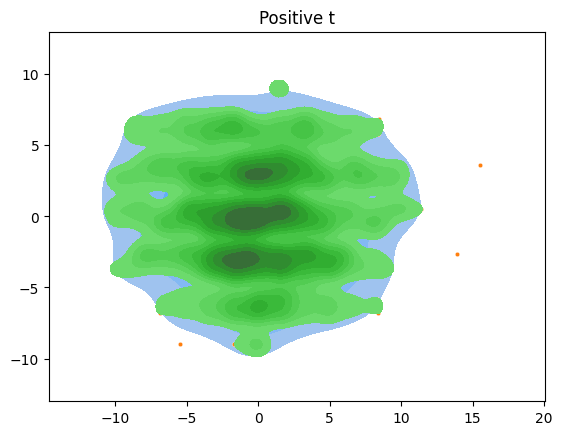

In [8]:
plt.ion()
f, ax = plt.subplots()
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], fill=True)
sn.scatterplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], s=10)
sn.kdeplot(x = MC_base1.detach().numpy()[:,0], y = MC_base1.detach().numpy()[:,1], bw_adjust=0.5, fill=True)
plt.title("Positive t")
plt.show()

In [ ]:
from google. colab import runtime
runtime.unassign()